# Market Access - Pacific Observatory
This notebook is a template workflow to run a baseline accessibility analysis for the Pacific Observatory. It uses various tools developed by the World Bank's Geospatial Operations Support Team (GOST).

This notebook focuses on a raster-based implementation of market access, using the motorized Global Friction Surface from the [Malaria Atlas Project](https://malariaatlas.org/project-resources/accessibility-to-healthcare/). Additionaly, it uses population data from [World Pop](https://hub.worldpop.org/project/categories?id=3) (Unconstrained UN-Adjusted 2020, 1km resolution).

## Data Download Links
- [World Pop Raster](https://data.worldpop.org/GIS/Population/Global_2000_2020_1km/2020/PNG/png_ppp_2020_1km_Aggregated.tif)
- [Friction Surface](https://malariaatlas.org/geoserver/ows?service=CSW&version=2.0.1&request=DirectDownload&ResourceId=Explorer:2020_motorized_travel_time_to_healthcare)

## 0. Setup
Import various packages required.

In [1]:
import sys, os
from os.path import join, expanduser, exists
import geopandas as gpd
import pandas as pd
from gadm import GADMDownloader
from tqdm import tqdm
import urllib.request

ERROR 1: PROJ: proj_create_from_database: Open of /home/jupyter-wb514197/.conda/envs/ox2/share/proj failed


In [2]:
## Visualization tools
# import folium as flm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from rasterio.plot import plotting_extent
from rasterio.plot import show
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx

In [3]:
# Raster
import rasterio as rio
import numpy as np
from shapely.geometry import Polygon, box, Point
import skimage.graph as graph

In [4]:
import country_converter as coco

The packages below were developed by GOST. They can be installed to the environment or referenced from a local folder.

In [5]:
sys.path.append(join(expanduser("~"), 'Repos', 'gostrocks', 'src'))
sys.path.append(join(expanduser("~"), 'Repos', 'GOSTNets_Raster', 'src'))
sys.path.append(join(expanduser("~"), 'Repos', 'GOSTnets'))
sys.path.append(join(expanduser("~"), 'Repos', 'GOST_Urban', 'src', 'GOST_Urban'))

In [6]:
import GOSTRocks.rasterMisc as rMisc
import GOSTNetsRaster.market_access as ma
import UrbanRaster as urban

In [7]:
# auto reload
%load_ext autoreload
%autoreload 2

## 1. Data Preparation

In [8]:
# adm0 = gpd.read_file(join(expanduser("~"), 'data', 'pacific', 'Adm0_Pacific_Edit.shp'))
adm1 = gpd.read_file(join(expanduser("~"), 'data', 'pacific', 'PIC_adm1.json'))

In [9]:
countries = adm1['ADM0_NAME'].unique()
countries

array(['Papua New Guinea', 'Kiribati', 'Kingdom of Tonga',
       'Federated States of Micronesia', 'Marshall Islands',
       'Solomon Islands', 'Vanuatu', 'Nauru', 'Palau', 'Tuvalu', 'Samoa',
       'Fiji'], dtype=object)

In [10]:
cc = coco.CountryConverter()
adm1.loc[:, 'iso'] = cc.pandas_convert(series=adm1.ADM0_PCODE, to='ISO3')

In [11]:
# country = 'Papua New Guinea'

In [12]:
# for country in tqdm(countries):
#     adm1_sel = adm1.loc[adm1['ADM0_NAME'] == country].copy()
#     iso = adm1_sel['iso'].values[0].lower()
#     print(iso, country)

#     scratch_dir = join(expanduser("~"), 'data', 'market-access', iso)
#     if not exists(scratch_dir):
#         os.mkdir(scratch_dir, mode=0o777)
    
#     wp_url = f'https://data.worldpop.org/GIS/Population/Global_2000_2020_1km/2020/{iso.upper()}/{iso}_ppp_2020_1km_Aggregated.tif'
#     wp_path = join(expanduser("~"), 'data', 'worldpop', f'{iso}_ppp_2020_1km_Aggregated_UNadj.tif') # Download from link above
#     urllib.request.urlretrieve(wp_url, wp_path)

#     urban_calculator = urban.urbanGriddedPop(wp_path)
    
#     if country in ['Papua New Guinea', 'Vanuatu', 'Solomon Islands', 'Fiji']:
#         density_thresh = 190
#         total_pop_thresh = 5000
#     else:
#         density_thresh = 50
#         total_pop_thresh = 1000
#     urban_extents = urban_calculator.calculateUrban(
#         densVal=190, totalPopThresh=5000,  # changed the density value to capute more remote cities
#         smooth=True, queen=False, verbose=True
#         )
#     dests = urban_extents.copy()
#     dests.loc[:, 'geometry'] = dests.geometry.centroid
#     dests.to_file(join(scratch_dir, f'urban_{iso}.json'), driver='GeoJSON')

In [20]:
for country in tqdm(countries):
    if country in ['Fiji', 'Kiribati']:
        continue
    else:
        adm1_sel = adm1.loc[adm1['ADM0_NAME'] == country].copy()
        iso = adm1_sel['iso'].values[0].lower()
        print(iso, country)

        scratch_dir = join(expanduser("~"), 'data', 'market-access', iso)
        if not exists(scratch_dir):
            os.mkdir(scratch_dir, mode=0o777)
        
        wp_url = f'https://data.worldpop.org/GIS/Population/Global_2000_2020_1km/2020/{iso.upper()}/{iso}_ppp_2020_1km_Aggregated.tif'
        wp_path = join(expanduser("~"), 'data', 'worldpop', f'{iso}_ppp_2020_1km_Aggregated_UNadj.tif') # Download from link above
        urllib.request.urlretrieve(wp_url, wp_path)

        urban_calculator = urban.urbanGriddedPop(wp_path)
        
        if country in ['Papua New Guinea', 'Vanuatu', 'Solomon Islands']:
            density_thresh = 190
            total_pop_thresh = 5000
        else:
            density_thresh = 50
            total_pop_thresh = 1000
        urban_extents = urban_calculator.calculateUrban(
            densVal=190, totalPopThresh=5000,  # changed the density value to capute more remote cities
            smooth=True, queen=False, verbose=True
            )
        dests = urban_extents.copy()
        dests.loc[:, 'geometry'] = dests.geometry.centroid

        gfs_path = join(expanduser("~"), 'data', 'friction', '2020_motorized_friction_surface.geotiff') # Download from link above
        gfs_rio = rio.open(gfs_path)
        out_travel_surface = join(scratch_dir, f"travel_surface_motorized_{iso}.tif")
        rMisc.clipRaster(gfs_rio, adm1_sel, out_travel_surface, crop=False)

        travel_surf = rio.open(out_travel_surface)
        pop_surf = rio.open(wp_path)

        out_pop_surface_std = join(scratch_dir, "WP_2020_1km_STD.tif")
        rMisc.standardizeInputRasters(pop_surf, travel_surf, out_pop_surface_std, resampling_type="nearest")

        pop_surf = rio.open(out_pop_surface_std)
        pop = pop_surf.read(1, masked=False)
        indices = list(np.ndindex(pop.shape))
        xys = [Point(pop_surf.xy(ind[0], ind[1])) for ind in indices]
        res_df = pd.DataFrame({
            'spatial_index': indices, 
            'xy': xys, 
            'pop': pop.flatten()
        })
        res_df['pointid'] = res_df.index

        inG_data = travel_surf.read(1) * 1000 
        mcp = graph.MCP_Geometric(inG_data)
        res = ma.calculate_travel_time(travel_surf, mcp, dests)[0]

        res_df.loc[:, 'tt_city_min'] = res.flatten()
        # remove values where pop is 0 or nan
        res_df = res_df.loc[res_df['pop']>=0].copy()
        # res_df = res_df.loc[res_df['pop']!=0].copy()
        res_df = res_df.loc[~(res_df['pop'].isna())].copy()

        res_df.loc[:,'xy'] = res_df.loc[:,'xy'].apply(lambda x: Point(x))
        origins = gpd.GeoDataFrame(res_df, geometry='xy', crs='EPSG:4326')
        origins.rename(columns={'xy':'geometry'}, inplace=True)
        origins.set_geometry('geometry', inplace=True)
        # convert travel time to hours
        origins.loc[:, "tt_city_min_hrs"] = origins.loc[:, "tt_city_min"] / 60
        tt_raster = join(scratch_dir, f"tt_city_min_motorized_friction.tif")
        rMisc.rasterizeDataFrame(
            inD = origins,
            outFile = tt_raster,
            idField = 'tt_city_min_hrs',
            templateRaster = out_travel_surface,
            nodata = travel_surf.nodata
        )

  0%|          | 0/12 [00:00<?, ?it/s]

png Papua New Guinea
13:46:37	: Read in urban data
13:46:37	: Creating Shape 0


/tmp/ipykernel_1236030/2636240109.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid
  8%|▊         | 1/12 [03:05<33:58, 185.29s/it]

ton Kingdom of Tonga
13:49:41	: Read in urban data
13:49:41	: Creating Shape 0


/tmp/ipykernel_1236030/2636240109.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid
 25%|██▌       | 3/12 [03:33<08:47, 58.58s/it] 

fsm Federated States of Micronesia
13:50:09	: Read in urban data
13:50:09	: Creating Shape 0


/tmp/ipykernel_1236030/2636240109.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid
 33%|███▎      | 4/12 [06:04<12:03, 90.38s/it]

mhl Marshall Islands
13:52:40	: Read in urban data
13:52:40	: Creating Shape 0


/tmp/ipykernel_1236030/2636240109.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid
 42%|████▏     | 5/12 [06:53<08:57, 76.78s/it]

slb Solomon Islands
13:53:29	: Read in urban data
13:53:29	: Creating Shape 0


/tmp/ipykernel_1236030/2636240109.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid
 50%|█████     | 6/12 [08:05<07:32, 75.36s/it]

vut Vanuatu
13:54:42	: Read in urban data
13:54:42	: Creating Shape 0


/tmp/ipykernel_1236030/2636240109.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid
 58%|█████▊    | 7/12 [08:25<04:49, 58.00s/it]

nru Nauru
13:55:01	: Read in urban data
13:55:01	: Creating Shape 0


/tmp/ipykernel_1236030/2636240109.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid
 67%|██████▋   | 8/12 [08:27<02:41, 40.40s/it]

plw Palau
13:55:03	: Read in urban data
13:55:03	: Creating Shape 0


/tmp/ipykernel_1236030/2636240109.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid
 75%|███████▌  | 9/12 [08:40<01:35, 31.96s/it]

tuv Tuvalu
13:55:16	: Read in urban data
13:55:16	: Creating Shape 0


/tmp/ipykernel_1236030/2636240109.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid
 83%|████████▎ | 10/12 [08:53<00:52, 26.42s/it]

wsm Samoa
13:55:29	: Read in urban data
13:55:29	: Creating Shape 0


/tmp/ipykernel_1236030/2636240109.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid
100%|██████████| 12/12 [08:55<00:00, 44.66s/it]


## Loop with maps

In [45]:
output_dir = join(expanduser("~"), 'data', 'market-access-out')
if not exists(output_dir):
    os.mkdir(output_dir, mode=0o777)

  0%|          | 0/12 [00:00<?, ?it/s]

png Papua New Guinea
07:55:34	: Read in urban data
07:55:34	: Creating Shape 0


/tmp/ipykernel_2764274/2007673966.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid
  8%|▊         | 1/12 [00:05<01:03,  5.79s/it]/tmp/ipykernel_2764274/2007673966.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid


ton Kingdom of Tonga
07:55:40	: Read in urban data
07:55:40	: Creating Shape 0


 25%|██▌       | 3/12 [00:08<00:23,  2.57s/it]

fsm Federated States of Micronesia
07:55:42	: Read in urban data
07:55:42	: Creating Shape 0


/tmp/ipykernel_2764274/2007673966.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid
 33%|███▎      | 4/12 [00:12<00:23,  2.95s/it]

mhl Marshall Islands
07:55:46	: Read in urban data
07:55:46	: Creating Shape 0


/tmp/ipykernel_2764274/2007673966.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid
 42%|████▏     | 5/12 [00:16<00:23,  3.33s/it]

slb Solomon Islands
07:55:50	: Read in urban data
07:55:50	: Creating Shape 0


/tmp/ipykernel_2764274/2007673966.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid
 50%|█████     | 6/12 [00:20<00:21,  3.59s/it]

vut Vanuatu
07:55:54	: Read in urban data
07:55:54	: Creating Shape 0


/tmp/ipykernel_2764274/2007673966.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid
 58%|█████▊    | 7/12 [00:23<00:16,  3.37s/it]/tmp/ipykernel_2764274/2007673966.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid
/home/jupyter-wb514197/.conda/envs/ox2/lib/python3.12/site-packages/contextily/tile.py:614: UserWarning: The inferred zoom level of 14 is not valid for the current tile provider (valid zooms: 0 - 13).
  warnings.warn(msg)


nru Nauru
07:55:57	: Read in urban data
07:55:57	: Creating Shape 0


 67%|██████▋   | 8/12 [00:26<00:13,  3.38s/it]/tmp/ipykernel_2764274/2007673966.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid


plw Palau
07:56:01	: Read in urban data
07:56:01	: Creating Shape 0


 75%|███████▌  | 9/12 [00:29<00:09,  3.24s/it]/tmp/ipykernel_2764274/2007673966.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid


tuv Tuvalu
07:56:04	: Read in urban data
07:56:04	: Creating Shape 0


 83%|████████▎ | 10/12 [00:32<00:06,  3.13s/it]/tmp/ipykernel_2764274/2007673966.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid


wsm Samoa
07:56:06	: Read in urban data
07:56:06	: Creating Shape 0


100%|██████████| 12/12 [00:34<00:00,  2.88s/it]


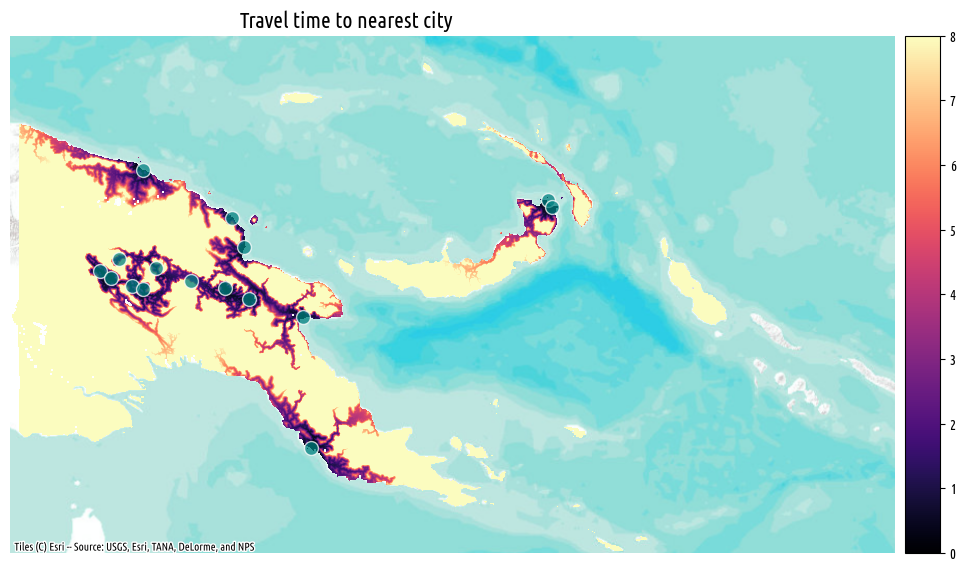

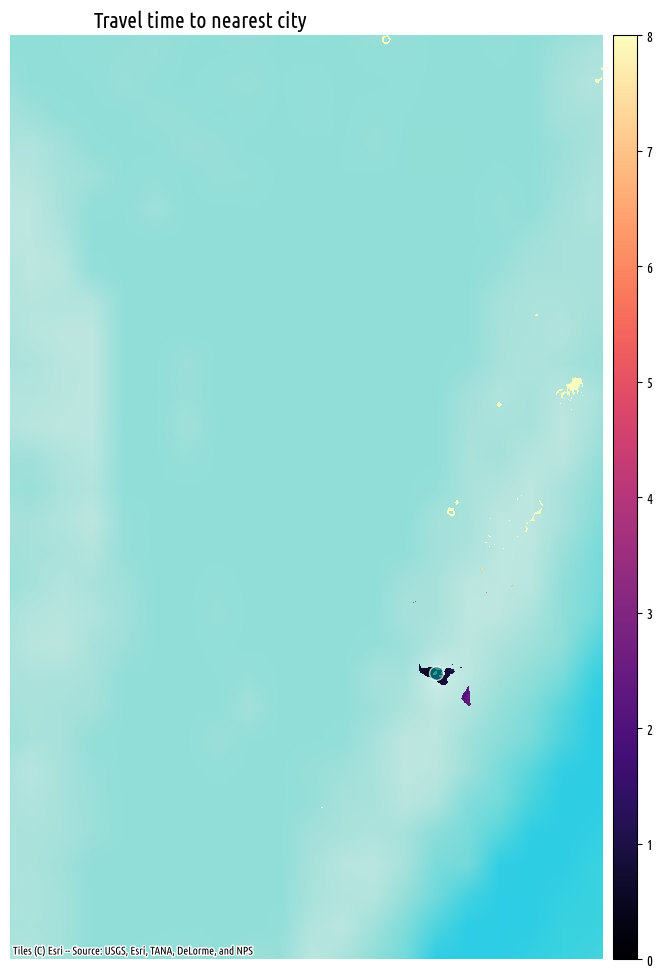

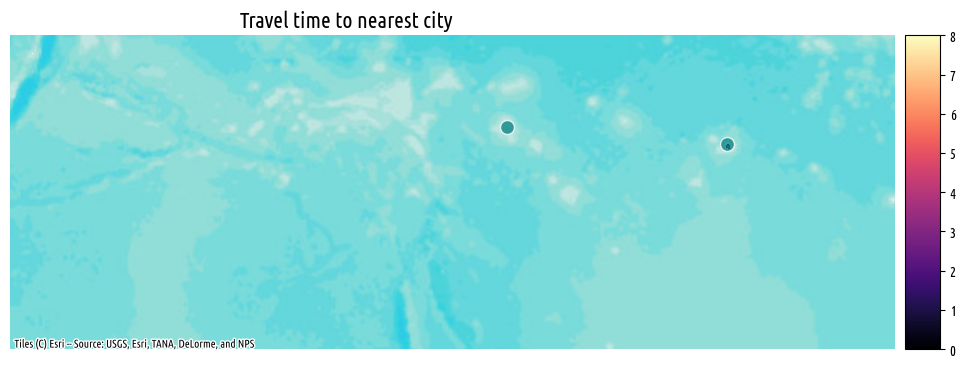

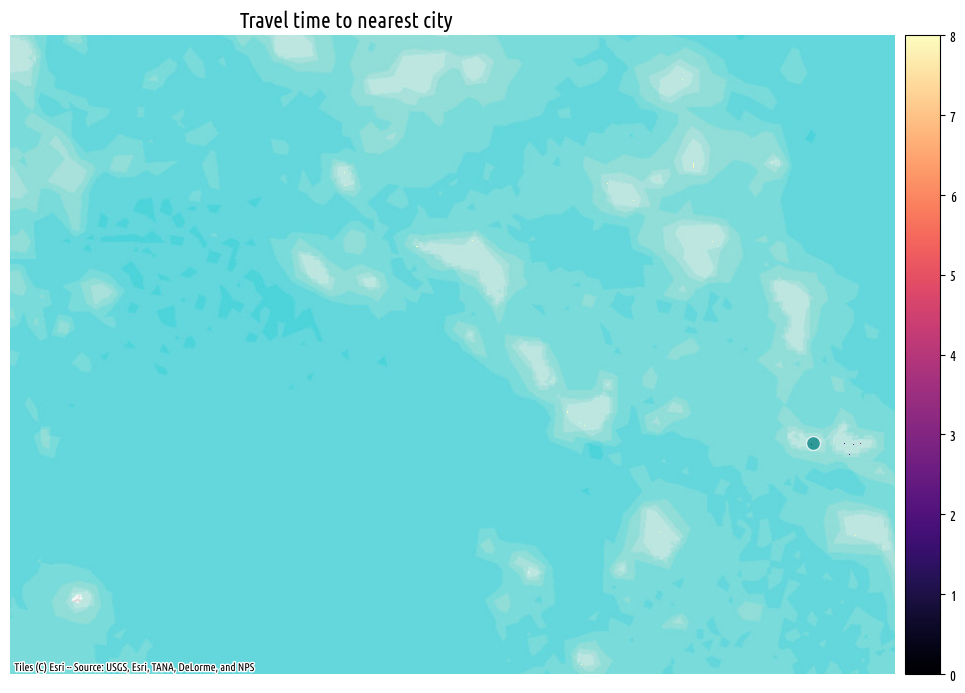

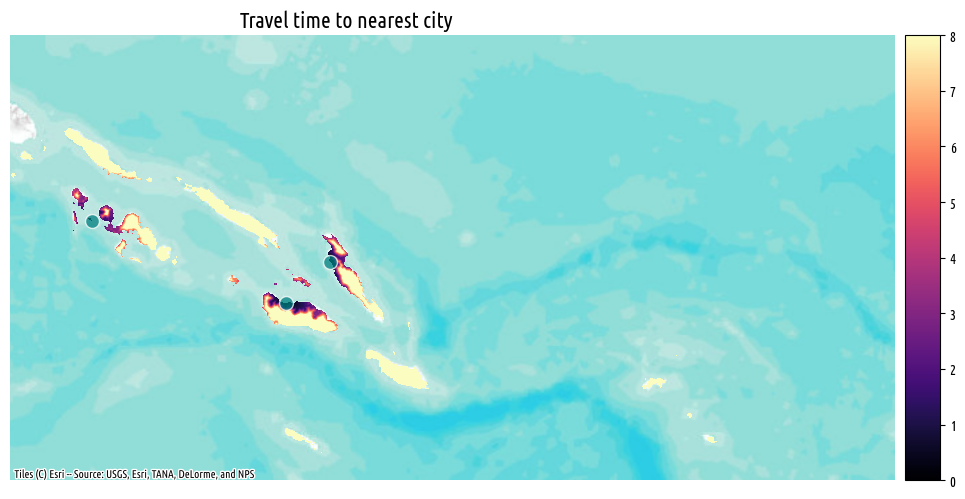

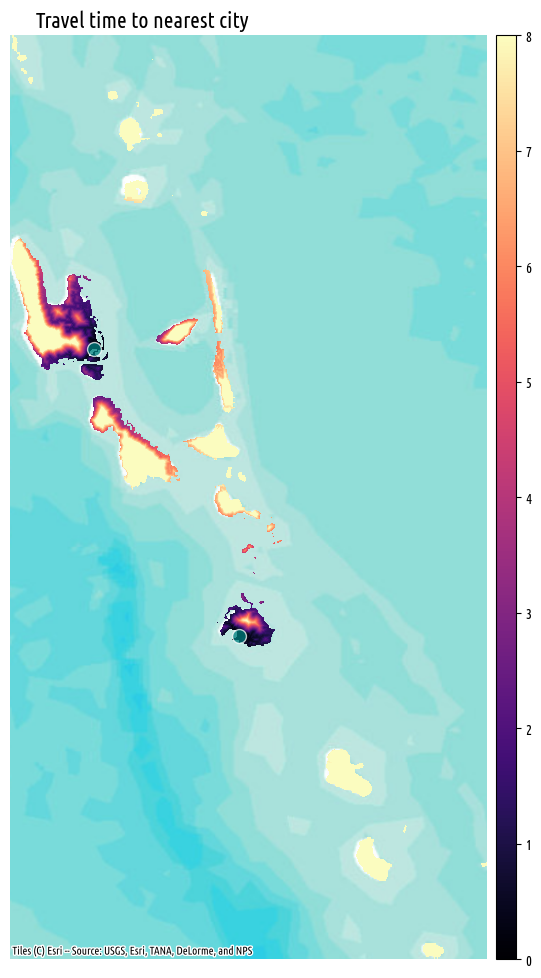

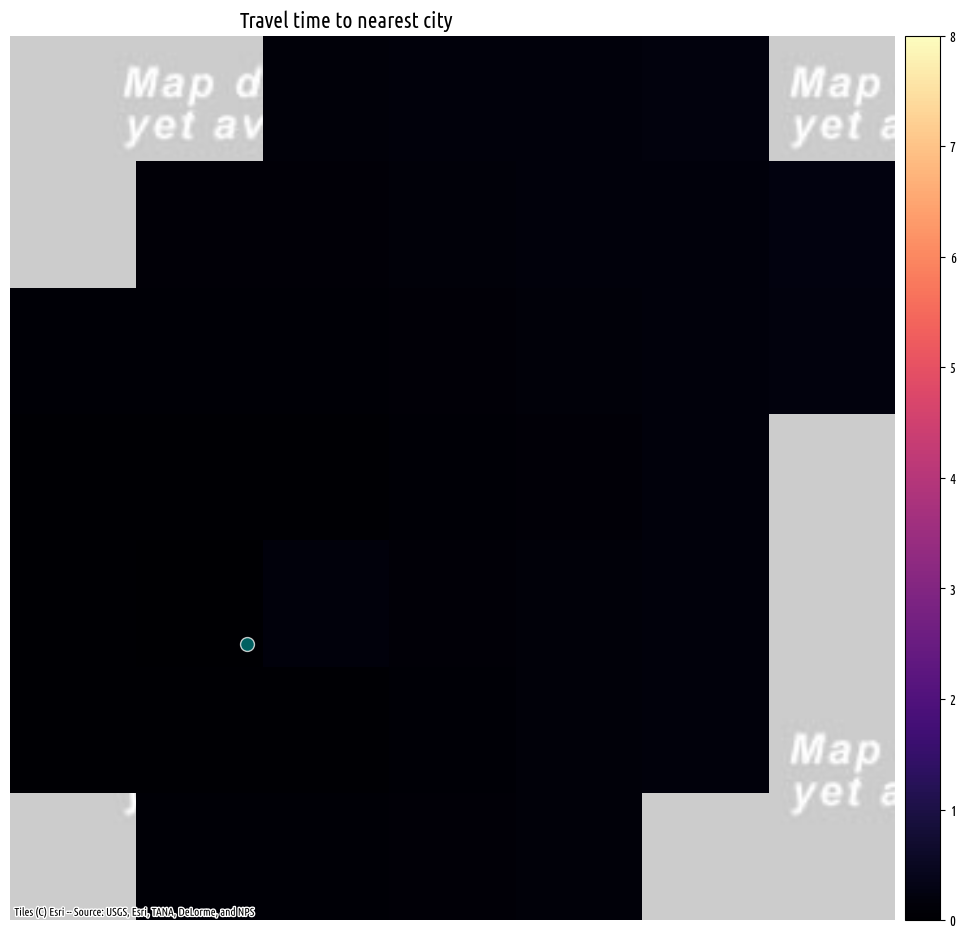

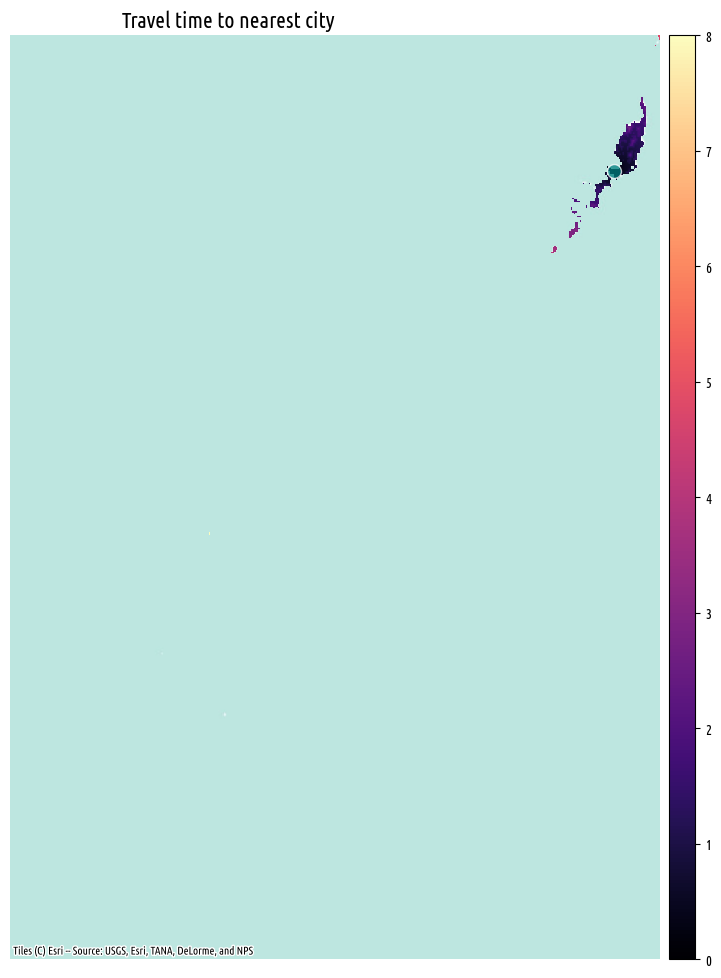

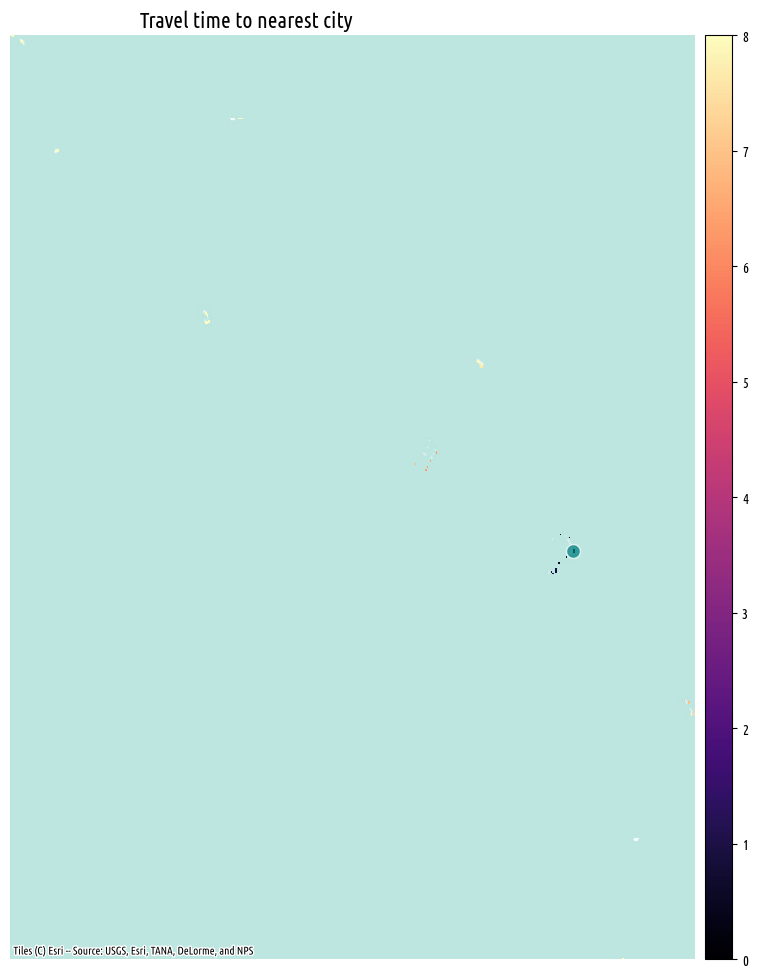

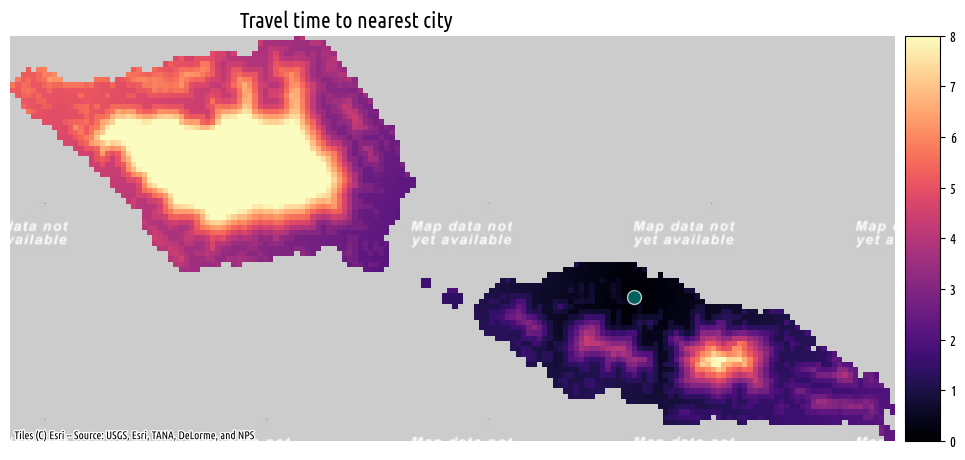

In [48]:
for country in tqdm(countries):
    if country in ['Fiji', 'Kiribati']:
        continue
    else:
        adm1_sel = adm1.loc[adm1['ADM0_NAME'] == country].copy()
        iso = adm1_sel['iso'].values[0].lower()
        print(iso, country)

        scratch_dir = join(expanduser("~"), 'data', 'market-access', iso)
        if not exists(scratch_dir):
            os.mkdir(scratch_dir, mode=0o777)
        
        wp_path = join(expanduser("~"), 'data', 'worldpop', f'{iso}_ppp_2020_1km_Aggregated_UNadj.tif') # Download from link above
        urban_calculator = urban.urbanGriddedPop(wp_path)
        urban_extents = urban_calculator.calculateUrban(
            densVal=190, totalPopThresh=5000,  # changed the density value to capute more remote cities
            smooth=True, queen=False, verbose=True
            )
        dests = urban_extents.copy()
        dests.loc[:, 'geometry'] = dests.geometry.centroid
        tt_raster = join(scratch_dir, f"tt_city_min_motorized_friction.tif")
        tt_rio = rio.open(tt_raster)

        ## Map
        figsize = (12, 12)
        fig, ax = plt.subplots(1, 1,  figsize = figsize)

        ax.set_title("Travel time to nearest city", fontsize=16, horizontalalignment='right')
        plt.axis('off')

        ext = plotting_extent(tt_rio)
        im = ax.imshow(tt_rio.read(1, masked=True), vmin=0, vmax=8, cmap='magma', extent=ext)

        dests.plot(ax=ax, facecolor='teal', edgecolor='white', markersize=100, alpha=0.75)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size="4%", pad=0.1)
        cb = fig.colorbar(im, cax=cax, orientation='vertical')

        ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTerrain, crs='EPSG:4326', zorder=-1)

        txt="Cities are defined as clusters of at least 5,000 people with a density of at least 190 ppl. per sq. km."
        txt2 = "Travel time is estimated using the motorized global friction surface (2020)"

        # plt.figtext(0.3, 0.08, txt, wrap=True, horizontalalignment='left', fontsize=10)
        # plt.figtext(0.3, 0.06, txt2, wrap=True, horizontalalignment='left', fontsize=10)
        # plt.figtext(0.7, 0.89, "Travel Time (hrs.)", wrap=False, fontsize=10)
        plt.savefig(join(output_dir, f"travel-time-friction-{iso}.png"), dpi=300, bbox_inches='tight', facecolor='white')

## Map Results

In [14]:
country = 'Vanuatu'

In [16]:
adm1_sel = adm1.loc[adm1['ADM0_NAME'] == country].copy()
iso = adm1_sel['iso'].values[0].lower()
print(iso, country)

scratch_dir = join(expanduser("~"), 'data', 'market-access', iso)
if not exists(scratch_dir):
    os.mkdir(scratch_dir, mode=0o777)

wp_url = f'https://data.worldpop.org/GIS/Population/Global_2000_2020_1km/2020/{iso.upper()}/{iso}_ppp_2020_1km_Aggregated.tif'
wp_path = join(expanduser("~"), 'data', 'worldpop', f'{iso}_ppp_2020_1km_Aggregated_UNadj.tif') # Download from link above

vut Vanuatu


In [25]:
urban_calculator = urban.urbanGriddedPop(wp_path)

# if country in ['Papua New Guinea', 'Vanuatu', 'Solomon Islands']:
#     density_thresh = 190
#     total_pop_thresh = 5000
# else:
#     density_thresh = 50
#     total_pop_thresh = 1000
urban_extents = urban_calculator.calculateUrban(
    densVal=190, totalPopThresh=5000,  # changed the density value to capute more remote cities
    smooth=True, queen=False, verbose=True
    )
dests = urban_extents.copy()
dests.loc[:, 'geometry'] = dests.geometry.centroid

07:36:44	: Read in urban data
07:36:44	: Creating Shape 0


/tmp/ipykernel_2764274/1272928172.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dests.loc[:, 'geometry'] = dests.geometry.centroid


In [ ]:
urban_calculator = urban.urbanGriddedPop(wp_path)

# if country in ['Papua New Guinea', 'Vanuatu', 'Solomon Islands']:
#     density_thresh = 190
#     total_pop_thresh = 5000
# else:
#     density_thresh = 50
#     total_pop_thresh = 1000
urban_extents = urban_calculator.calculateUrban(
    densVal=190, totalPopThresh=5000,  # changed the density value to capute more remote cities
    smooth=True, queen=False, verbose=True
    )
dests = urban_extents.copy()
dests.loc[:, 'geometry'] = dests.geometry.centroid

gfs_path = join(expanduser("~"), 'data', 'friction', '2020_motorized_friction_surface.geotiff') # Download from link above
gfs_rio = rio.open(gfs_path)
out_travel_surface = join(scratch_dir, f"travel_surface_motorized_{iso}.tif")
rMisc.clipRaster(gfs_rio, adm1_sel, out_travel_surface, crop=False)

travel_surf = rio.open(out_travel_surface)
pop_surf = rio.open(wp_path)

out_pop_surface_std = join(scratch_dir, "WP_2020_1km_STD.tif")
rMisc.standardizeInputRasters(pop_surf, travel_surf, out_pop_surface_std, resampling_type="nearest")

pop_surf = rio.open(out_pop_surface_std)
pop = pop_surf.read(1, masked=False)
indices = list(np.ndindex(pop.shape))
xys = [Point(pop_surf.xy(ind[0], ind[1])) for ind in indices]
res_df = pd.DataFrame({
    'spatial_index': indices, 
    'xy': xys, 
    'pop': pop.flatten()
})
res_df['pointid'] = res_df.index

inG_data = travel_surf.read(1) * 1000 
mcp = graph.MCP_Geometric(inG_data)
res = ma.calculate_travel_time(travel_surf, mcp, dests)[0]

res_df.loc[:, 'tt_city_min'] = res.flatten()
# remove values where pop is 0 or nan
res_df = res_df.loc[res_df['pop']>=0].copy()
# res_df = res_df.loc[res_df['pop']!=0].copy()
res_df = res_df.loc[~(res_df['pop'].isna())].copy()

res_df.loc[:,'xy'] = res_df.loc[:,'xy'].apply(lambda x: Point(x))
origins = gpd.GeoDataFrame(res_df, geometry='xy', crs='EPSG:4326')
origins.rename(columns={'xy':'geometry'}, inplace=True)
origins.set_geometry('geometry', inplace=True)
# convert travel time to hours
origins.loc[:, "tt_city_min_hrs"] = origins.loc[:, "tt_city_min"] / 60
tt_raster = join(scratch_dir, f"tt_city_min_motorized_friction.tif")
rMisc.rasterizeDataFrame(
    inD = origins,
    outFile = tt_raster,
    idField = 'tt_city_min_hrs',
    templateRaster = out_travel_surface,
    nodata = travel_surf.nodata
)

In [17]:
tt_raster = join(scratch_dir, f"tt_city_min_motorized_friction.tif")

In [18]:
tt_rio = rio.open(tt_raster)

In [38]:
tt_data = tt_rio.read(1, masked=True)

In [40]:
from rasterio.plot import show

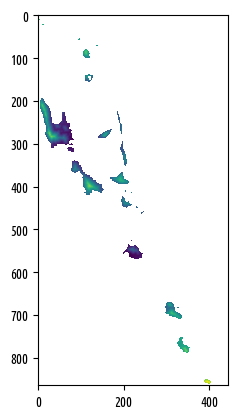

<Axes: >

In [41]:
show(tt_data)

In [20]:
# ext_custom = tuple(np.add(ext, (-1, +1, -1, +1)))

In [21]:
# ctx.providers

In [22]:
# ctx.providers.Esri

In [23]:
plt.rcParams["font.family"] = "Ubuntu Condensed"

Text(0.7, 0.89, 'Travel Time (hrs.)')

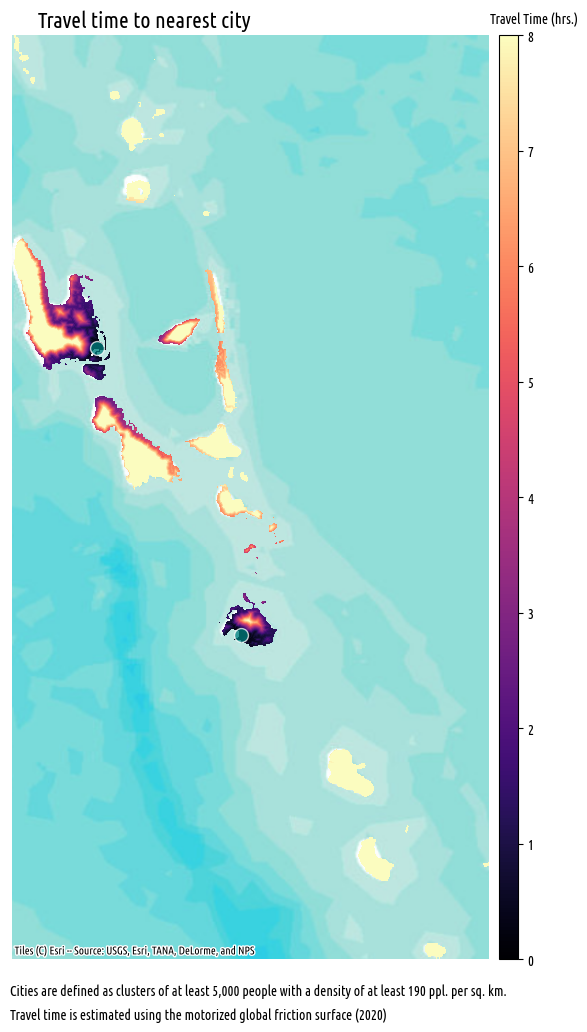

In [44]:
figsize = (12, 12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)

ax.set_title("Travel time to nearest city", fontsize=16, horizontalalignment='right')
plt.axis('off')

ext = plotting_extent(tt_rio)
im = ax.imshow(tt_rio.read(1, masked=True), vmin=0, vmax=8, cmap='magma', extent=ext)

dests.plot(ax=ax, facecolor='teal', edgecolor='white', markersize=100, alpha=0.75)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="4%", pad=0.1)
cb = fig.colorbar(im, cax=cax, orientation='vertical')

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTerrain, crs='EPSG:4326', zorder=-1)

txt="Cities are defined as clusters of at least 5,000 people with a density of at least 190 ppl. per sq. km."
txt2 = "Travel time is estimated using the motorized global friction surface (2020)"

plt.figtext(0.3, 0.08, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.3, 0.06, txt2, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.7, 0.89, "Travel Time (hrs.)", wrap=False, fontsize=10)
plt.savefig(join(output_dir, f"travel-time-friction-vut.png"), dpi=300, bbox_inches='tight', facecolor='white')

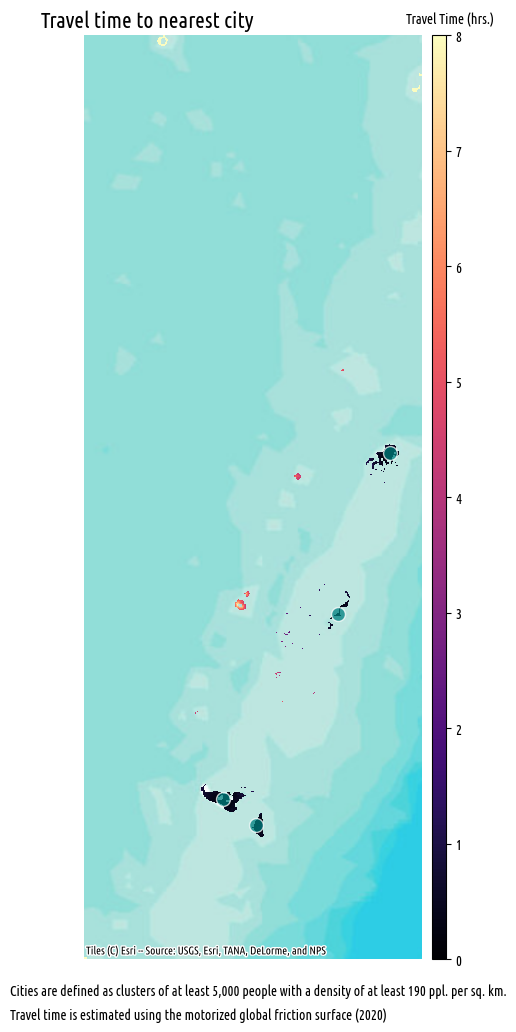

In [75]:
figsize = (12, 12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)

ax.set_title("Travel time to nearest city", fontsize=16, horizontalalignment='right')
plt.axis('off')
ext = plotting_extent(tt_rio)
im = ax.imshow(tt_rio.read(1), vmin=0, vmax=8, cmap='magma', extent=ext)
dests.plot(ax=ax, facecolor='teal', edgecolor='white', markersize=100, alpha=0.75)
# wpi.plot(ax=ax, facecolor='red', edgecolor='black', markersize=25, alpha=0.75)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="4%", pad=0.1)
cb = fig.colorbar(im, cax=cax, orientation='vertical')
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:4326', zorder=-1)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTerrain, crs='EPSG:4326', zorder=-1)
txt="Cities are defined as clusters of at least 5,000 people with a density of at least 190 ppl. per sq. km."
txt2 = "Travel time is estimated using the motorized global friction surface (2020)"

plt.figtext(0.3, 0.08, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.3, 0.06, txt2, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.63, 0.89, "Travel Time (hrs.)", wrap=False, fontsize=10)
plt.savefig(f"travel-time-friction-{iso}.png", dpi=300, bbox_inches='tight', facecolor='white')

In [125]:
# import matplotlib.font_manager
# flist = matplotlib.font_manager.get_font_names()
# print(flist)